Reference for code:
* [Github](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid9.ipynb), 
* [YouTube](https://www.youtube.com/watch?v=8DrR_tpfg0Q)

Reference for horse image:
* [skimage](https://scikit-image.org/docs/dev/auto_examples/data/plot_general.html#sphx-glr-auto-examples-data-plot-general-py))


In [7]:
import pandas as pd
import numpy as np

from skimage import data
from skimage import color
from skimage import io

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm


import numba 
from numba import jit 


The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{\partial t} $$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

in two dimensions and in discrete form, can be written as,

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [ ]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)


In [13]:
# use a sample image 
caller = getattr(data, "horse")
img = caller()
img = np.flip(img, axis=0)

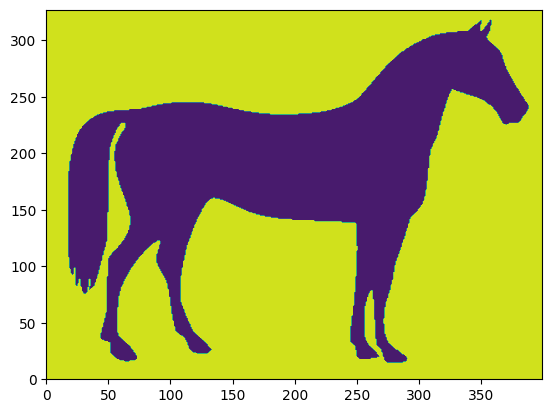

In [14]:
plt.contourf(img)

In [15]:
img.shape

(328, 400)

In [18]:
# seperate turkey from the image
turkey_bool = img<0.9

# split turkey in half
# turkey_bool[30,:] = False 

# thermal diffusivity of turkey 
a_turk = 1.32e-7

# overn and initaial temp 
rawturk_temp = 273.15 + 25
oven_temp = 273.15 + 165

# turkey at init turkey temp, 
init_heat = np.zeros([328,400]) + oven_temp
init_heat[turkey_bool] = rawturk_temp



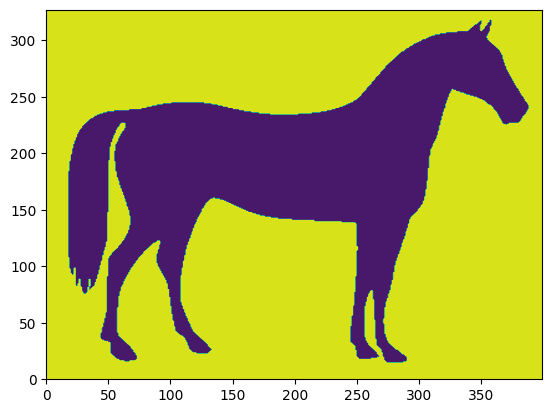

In [19]:
plt.contourf(init_heat)

In [21]:
times = 36000 # number of times dif eq iterations
times_snapshot = 3600 # number of snapshots we will take
f = int(times/times_snapshot) # number of iterations that pass between snapshots
heat_frames = np.zeros([times_snapshot, 328, 400])
heat_frames[0] = init_heat

In [23]:
# problem dimenisons
x = 0.5
dx = 0.5/100
dt = 1

Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [24]:
a_turk * dt / dx**2

0.005279999999999999

In [25]:
# set up numba function 

@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_turkey):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_turkey[j][i]:
                    a = a_turk
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

In [26]:
# run equations and get heat snap shots 
heat_frames = solve_heat(heat_frames, turkey_bool)

In [27]:
# convert to celcius 
heat_frames -= 273.15


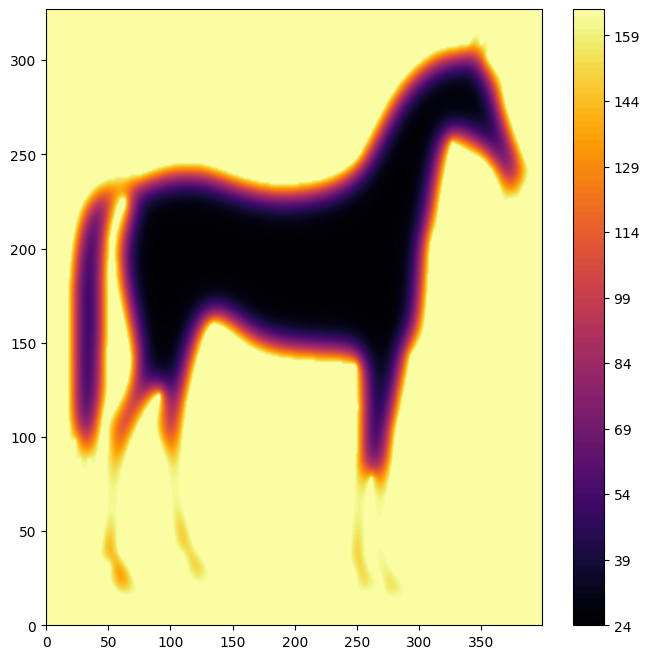

In [28]:
# plot of result
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(heat_frames[1000], 100, cmap=my_cmap, vmin=rawturk_temp-273.15, vmax=oven_temp-273.15)
plt.colorbar(a)